___
# ML Pipeline, Creating Inputs for Ensemble model
- Build 4 types of models
- Determine parameter space for each
- Select optimal parameters for each (with cross-validation)
- Show results of optimized models per model type
- Input to Ensemble Model
- Review Results


In [1]:
# Import needed packages
import pandas as pd 
import pickle
import os

# Multiple Outputs Per Code Block 
%config InteractiveShell.ast_node_interactivity = 'all'

# Set working directory
os.chdir('C:/Users/WulfN/Python Projects/Meta-Transaction-Risk-Classification') 

# Read in modeling dataframe
meta_model_df = pd.read_pickle('./meta_model_df.pkl')

# Read in needed functions originally defined in meta_ml script
%run functions\class_imbalance_train_test_split.py
%run functions\meta_confusion_matrix.py


In [2]:
# Setting param for following methods that are dependent on the target variable
target_variable = 'anomaly_binary'

objective = 'binary' if target_variable == 'anomaly_binary' else 'multiclass'

# Test / Train Downsownapled split (Same as ml script due to random seeds)
x_train, x_test, y_train, y_test = class_imbalance_train_test_split(meta_model_df, target_variable, testset_size = .25)

Class Imbalance
anomaly_binary
0    54079
1     4871
Name: count, dtype: int64


Training Set Class Balance
anomaly_binary
1    4871
0    4871
Name: count, dtype: int64


Validation Set Class Balance 
anomaly_binary
0    18026
1     1624
Name: count, dtype: int64


## ML Pipeline
- 4 model types
    - KNN, Logistic Regression, LightGBM, RandomForest
- 4 parameter spaces
    - Each is searched with bayesian optimization
- Up to 32 models of a model type are built
    - 3 fold cross validation to select robust optimized model

In [3]:
%%capture
# Testing Model Pipeline with Bayesian Optimization

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
import skopt
from skopt.space import Real, Categorical, Integer

# Define the models and their parameter spaces in a dictionary
models_and_param_spaces = {
    "KNN": { 
        "model": KNeighborsClassifier(),
        "param_space": {
            "model__n_neighbors": Integer(1, 30),
            "model__weights": Categorical(['uniform', 'distance']),
            "model__algorithm": Categorical(['ball_tree', 'kd_tree']),
            "model__metric": Categorical(['euclidean', 'manhattan'])
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(), 
        "param_space": {
            "model__solver": Categorical(['saga', 'lbfgs']),
            "model__C": Real(.01, 1, prior = 'uniform')
        }
    },
    "LightGBM": { 
        "model": LGBMClassifier(),
        "param_space": {
            "model__max_depth": Integer(1, 12),
            'model__learning_rate': Real(0.01, 1, prior = 'uniform'),
            'model__num_leaves': Integer(10, 50),
            'model__max_depth': Integer(3, 10),
            'model__boosting_type': Categorical(['gbdt', 'dart']),
            'model__feature_fraction': Real(0.1, 1, prior = 'uniform'),
            'model__subsample': Real(0.1, 1, prior = 'uniform'),
            'model__verbosity': [-1],
            'model__force_col_wise': [True]
        }
    },
    "RandomForest": { 
        "model": RandomForestClassifier(),
        "param_space": {
            "model__n_estimators": Integer(10, 30),
            "model__max_depth": Integer(1, 12),
            "model__min_samples_split": Integer(2, 20),
            "model__min_samples_leaf": Integer(4, 20),
        }
    }
}

# Perform BayesSearchCV for each model
results = {}
for name, config in models_and_param_spaces.items():
    # Set up pipeline 
    pipe = Pipeline([
        ('model', config['model'])
    ])
    
    # Define the BayesSearchCV object
    opt = skopt.BayesSearchCV(
        estimator = pipe,
        search_spaces = config['param_space'],
        n_iter = 32,  # Number of parameter settings sampled
        cv = 3,       # 3-fold cross-validation
        n_jobs = -1,  # Use all cores
        random_state = 100
    )
    
    # Fit the model
    opt.fit(x_train, y_train); 
    
    # Store the results
    results[name] = {
        "best_score": opt.best_score_,
        "best_params": opt.best_params_
    }

### Training Model Results
- scores are inflated due to the training set not having a class imbalance

In [4]:
# Display the results
for model_name, result in results.items():
    print(f"{model_name} - Best Score: {result['best_score']:.4f}")
    print(f"Best Parameters: {result['best_params']}\n")

KNN - Best Score: 0.8777
Best Parameters: OrderedDict([('model__algorithm', 'ball_tree'), ('model__metric', 'manhattan'), ('model__n_neighbors', 10), ('model__weights', 'distance')])

LogisticRegression - Best Score: 0.8974
Best Parameters: OrderedDict([('model__C', 0.8184104191339556), ('model__solver', 'lbfgs')])

LightGBM - Best Score: 0.9049
Best Parameters: OrderedDict([('model__boosting_type', 'gbdt'), ('model__feature_fraction', 0.20194499998410062), ('model__force_col_wise', True), ('model__learning_rate', 0.4325319204713131), ('model__max_depth', 10), ('model__num_leaves', 26), ('model__subsample', 0.39719108827151306), ('model__verbosity', -1)])

RandomForest - Best Score: 0.9048
Best Parameters: OrderedDict([('model__max_depth', 12), ('model__min_samples_leaf', 5), ('model__min_samples_split', 2), ('model__n_estimators', 11)])



### Results on validation set

In [12]:
%%capture
# Checking models with optimized parameters on the validation
KNN_model = KNeighborsClassifier(algorithm = 'ball_tree', metric = 'manhattan', n_neighbors = 10, weights = 'distance'); 
Log_model = LogisticRegression(C = 0.8184104191339556, solver = 'lbfgs'); 
LGBM_model = LGBMClassifier(boosting_type = 'gbdt', feature_fraction = 0.20194499998410062, verbosity = -1, force_col_wise = True,
                            learning_rate = 0.4325319204713131, max_depth = 10, num_leaves = 26, subsample = 0.39719108827151306); 
RF_model = RandomForestClassifier(max_depth = 4, min_samples_leaf = 10, min_samples_split = 15, n_estimators = 30);  

# Fit models on training set ...again (should be saved in the loop above instead)
KNN_val = KNN_model.fit(x_train, y_train)
Log_val = Log_model.fit(x_train, y_train)
RF_val = RF_model.fit(x_train, y_train)
LGBM_val = LGBM_model.fit(x_train, y_train)

# Generate predictions
KNN_pred = KNN_val.predict(x_test)
Log_pred = Log_val.predict(x_test)
RF_pred = RF_val.predict(x_test)
LGBM_pred = LGBM_val.predict(x_test)

### Confusion Matrices for each model

KNN Model Confusion Matrix
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     18026
           1       0.27      0.96      0.43      1624

    accuracy                           0.79     19650
   macro avg       0.63      0.87      0.65     19650
weighted avg       0.94      0.79      0.83     19650





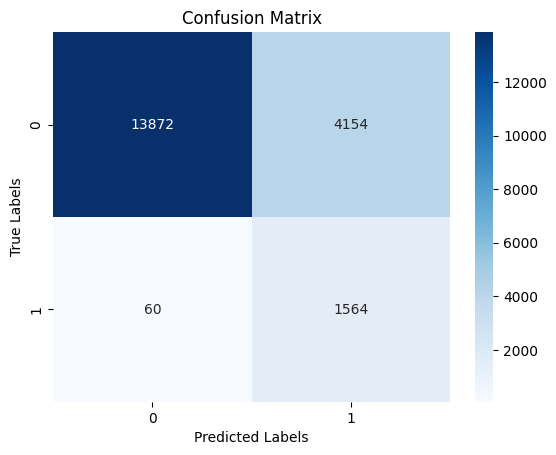

In [13]:
print('KNN Model Confusion Matrix')
meta_confusion_matrix(KNN_pred, y_test, objective)

Logistic Regression Model Confusion Matrix
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     18026
           1       0.32      0.99      0.48      1624

    accuracy                           0.82     19650
   macro avg       0.66      0.90      0.69     19650
weighted avg       0.94      0.82      0.86     19650





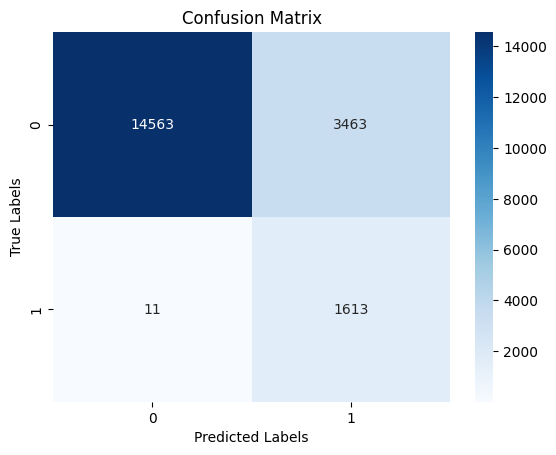

In [14]:
print('Logistic Regression Model Confusion Matrix')
meta_confusion_matrix(Log_pred, y_test, objective)

Random Forest Model Confusion Matrix
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     18026
           1       0.33      1.00      0.50      1624

    accuracy                           0.83     19650
   macro avg       0.67      0.91      0.70     19650
weighted avg       0.94      0.83      0.87     19650





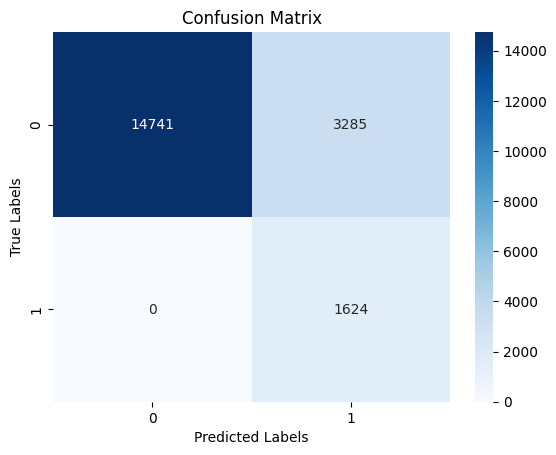

In [15]:
print('Random Forest Model Confusion Matrix')
meta_confusion_matrix(RF_pred, y_test, objective)

Light GBM Model Confusion Matrix
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     18026
           1       0.33      0.99      0.50      1624

    accuracy                           0.83     19650
   macro avg       0.66      0.91      0.70     19650
weighted avg       0.94      0.83      0.87     19650





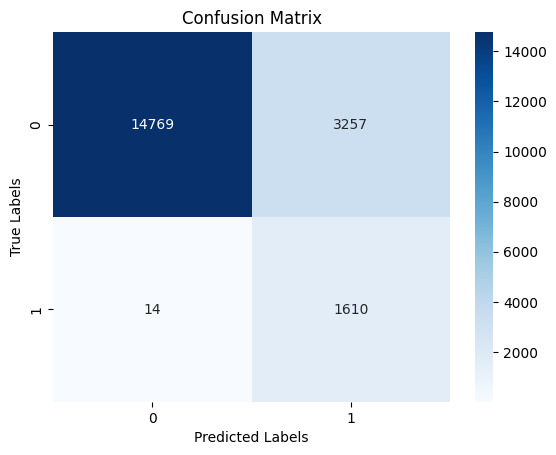

In [16]:
print('Light GBM Model Confusion Matrix')
meta_confusion_matrix(LGBM_pred, y_test, objective)

- Of these 4 models, Random Forest performs best
- LightGBM peforms slightly worse
    - Fewer rounds of cross validation
    - Different parameter space than prior Light GBM models
- Less sophisticated models (logistic regression and KNN) perform worse


## Ensemble Modeling (with ensemble input models)
- Practice writing ensemble models with multi-model pipeline

In [18]:
%%capture
from sklearn.ensemble import StackingClassifier, VotingClassifier

# ensemble using vote and stack method
ensemble_vote = VotingClassifier(
    estimators = [('KNN', KNN_model), ('Log', Log_model), ('RF', RF_model), ('LGBM', LGBM_model)],
    voting = 'soft'); 

ensemble_stack = StackingClassifier(
    estimators = [('KNN', KNN_model), ('Log', Log_model), ('RF', RF_model), ('LGBM', LGBM_model)],
    final_estimator = LGBMClassifier()); 

# Fit the ensemble models
ensemble_vote_fit = ensemble_vote.fit(x_train, y_train); 
ensemble_stack_fit = ensemble_stack.fit(x_train, y_train); 

# Predictions for ensemble models
vote_pred = ensemble_vote_fit.predict(x_test)
stack_pred = ensemble_stack_fit.predict(x_test)

Voting Ensemble Confusion Matrix
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     18026
           1       0.33      1.00      0.50      1624

    accuracy                           0.83     19650
   macro avg       0.67      0.91      0.70     19650
weighted avg       0.94      0.83      0.87     19650





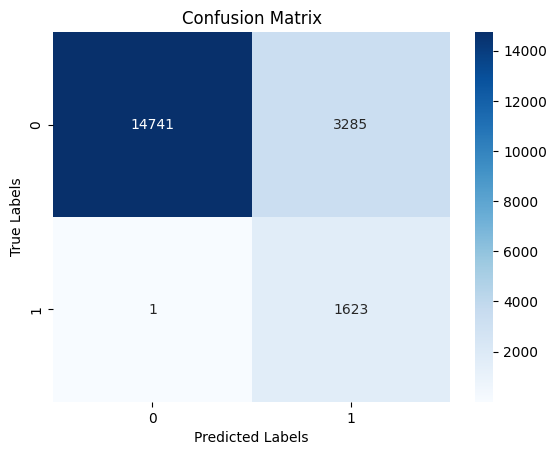

In [21]:
# Confusion matrices for each ensemble model
print('Voting Ensemble Confusion Matrix')
meta_confusion_matrix(vote_pred, y_test, objective)

Stacking Ensemble Confusion Matrix
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     18026
           1       0.33      0.95      0.49      1624

    accuracy                           0.84     19650
   macro avg       0.66      0.89      0.70     19650
weighted avg       0.94      0.84      0.87     19650





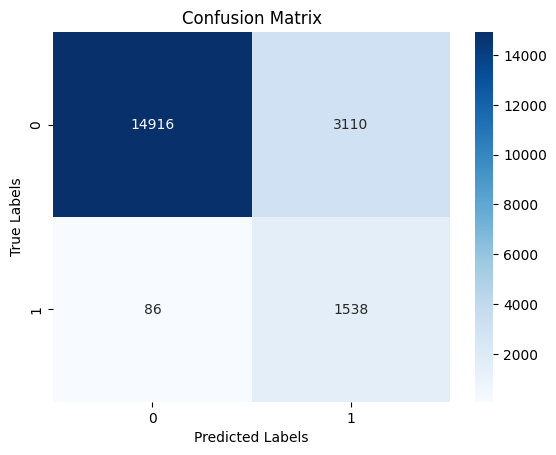

In [23]:
print('Stacking Ensemble Confusion Matrix')
meta_confusion_matrix(stack_pred, y_test, objective)

## Voting and Stacking Ensemble Model Performance
- Both achieve marginally better accuracy than prior models
    - Ensemble with Voting:
        - Accuracy: .83
        - *Misclassified high-risk transactions: 1*
    - Ensemble with Stacking:
        - Accuracy: .84
        - *Misclassified high-risk transactions: 90*

- For this dataset, these input models, and the goal of minimizing misclassified high-risk transactions, the voting ensemble model performed noticeably better. 
- Both achieve higher accuracy than the input models on the validation set alone.